In [20]:
from datetime import datetime
import numpy as np
import math
import copy
import os
import random
from initialization import make_world, get_tasks, initial_env, initial_agents, initial_work_region, initial_specification
from visualization import draw_path, draw_map, animate_solution
from heavy_WTS import total_states
from heavy_path_generation import heavy_path, get_work_map, get_path_cell2coord, get_independent_requests_tasks
from request_exchange import collect_deliver, complete_path

class bcolors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKCYAN = '\033[96m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    UNDERLINE = '\033[4m'

In [21]:
# dirname = os.path.dirname
# ABPATH = os.path.join(dirname(dirname(__file__)))

ABPATH = os.path.dirname(os.getcwd())

"""create the folder for the fig, file, output(video)"""
now = datetime.today().strftime('%Y-%m-%d')
fig_folder = ABPATH + '/figures/' + str(now)
file_folder = ABPATH + '/files/' + str(now)
output_folder = ABPATH + '/files/' + str(now) + '/output'
if not (os.path.exists(fig_folder)):
    os.makedirs(fig_folder)
if not (os.path.exists(file_folder)):
    os.makedirs(file_folder)
if not (os.path.exists(output_folder)):
    os.makedirs(output_folder)

Init heavy_duty agents:  [array([0, 0]), array([ 0, 19]), array([19, 19]), array([19,  0])] . Init light_duty agent:  [0, 4]


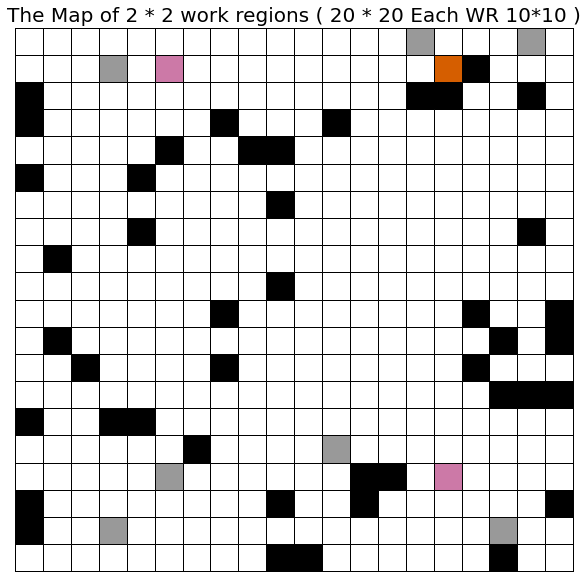

In [22]:
"""
Here is an example that all the requests can be accepted.
"""
#  initial map
num_agent_heavy = 4
num_agent_light = 1
map_row, map_col = [20, 20]
#  initial agents and specifications
# agents_heavy, [agents_light] = initial_agents(map_list, num_agent_heavy, num_agent_light)
agents_heavy = [np.array([0, 0]), np.array([0, 19]), np.array([19, 19]), np.array([19, 0])]
agents_light = [0, 4]
print("Init heavy_duty agents: ", agents_heavy, ". Init light_duty agent: ", agents_light)
obs = [[1, 16], [2, 0], [2, 14], [2, 15], [2, 18], [2, 18], [3, 0], [3, 7],
       [3, 11], [4, 5], [4, 5], [4, 8], [4, 9], [5, 0], [5, 4], [6, 9],
       [7, 4], [7, 18], [8, 1], [9, 9], [10, 7], [10, 16], [10, 19], [11, 1],
       [11, 17], [11, 19], [12, 2], [12, 7], [12, 16], [13, 17], [13, 18], [13, 19],
       [14, 0], [14, 0], [14, 3], [14, 4], [15, 6], [15, 6], [16, 12], [16, 13],
       [17, 0], [17, 9], [17, 12], [17, 19], [18, 0], [19, 9], [19, 10], [19, 17]]
map_original = np.zeros((map_row, map_col), dtype=int)

map_obstacle = copy.deepcopy(map_original)
for i in range(len(obs)):
    map_obstacle[obs[i][0]][obs[i][1]] = 1
states_dict_ori = total_states(map_obstacle)
work_region = [[0, 10, 0, 10], [0, 10, 10, 20], [10, 20, 10, 20], [10, 20, 0, 10]]
map_work_region = [get_work_map(map_obstacle, work_region, i) for i in range(num_agent_heavy)]
states_work_region = [total_states(map_work_region[i]) for i in range(num_agent_heavy)]

specifications = [[['G', '7', '10', 'w13'], ['E', '50', '55', 'w15', 'R3', 'meet']],
                  [['G', '12', '15', 'w4'], ['G', '30', '35', 'w8'], ['G', '67', '70', 'w15', 'R0', 'col']],
                  [['E', '8', '12', 'w43'], ['G', '25', '28', 'w75'], ['G', '60', '65', 'w55', 'R1', 'meet']],
                  [['E', '14', '30', 'w57'], ['E', '25', '30', 'w72']]]

task_type = get_tasks(specifications, states_work_region)
map_obs_work = copy.deepcopy(map_obstacle)
draw_map(map_obs_work, task_type, num_agent_heavy, fig_folder)

In [23]:
"""
--------------- light-duty robot module ---------------
"""
# initial the parameters of agents
r_i = 1
r_0 = 2
# hatch distance
h_a = 2 * r_0 - 2
# velocity / transition weight constraints
v_heavy = 1
v_light = max([math.ceil(
    ((2 * (work_region[i][3] - work_region[i][2] - 2 * r_0) + h_a) * v_heavy) /
    ((2 * r_0) - h_a)) for i in range(num_agent_heavy)])

In [24]:
"""
--------------- Mission decomposition ---------------
"""
path_existence = [[] for i in range(num_agent_heavy)]
initial_path = [[] for i in range(num_agent_heavy)]
independent_path = [[] for i in range(num_agent_heavy)]
independent_task = [[] for i in range(num_agent_heavy)]
independent_request = [[] for i in range(num_agent_heavy)]
independent_path_2d = [[] for i in range(num_agent_heavy)]

for i in range(num_agent_heavy):
    flag = "R" + str(i)
    # check if the initial specifications are satisfied
    initial_path[i] = heavy_path(map_work_region[i], specifications[i], file_folder, flag,
                                 agents_heavy[i]).get_path()
    # check if robot need to cooperate and provide best promise.  (bool) coop, promise
    if len(initial_path[i]) == 0:
        path_existence[i] = False
        print(path_existence[i])
        print("========There is no path satisfying the specification!========")
    else:
        path_existence[i] = True
if all(item is True for item in path_existence):
    for i in range(num_agent_heavy):
        independent_task, independent_request = get_independent_requests_tasks(specifications, map_work_region,
                                                                               agents_heavy, file_folder)
        independent_path[i] = heavy_path(map_work_region[i], independent_task[i], file_folder, flag,
                                         agents_heavy[i]).get_path()
        independent_path_2d[i] = get_path_cell2coord(independent_path[i], states_work_region[i])

The initial position is  w0
The initial position is  w0
Buildfile: /home/wei/uppaal64-4.1.26/demo/ModelDemo/build.xml

-pre-init:

-init-private:

-init-user:

-init-project:

-init-macrodef-property:

-init-modules-supported:

-do-init:

-post-init:

-init-check:

-init-ap-cmdline-properties:

-init-macrodef-modulename:

-init-source-module-properties:

-init-macrodef-javac-with-module:

-init-macrodef-javac-with-processors:

-init-macrodef-javac-without-processors:

-init-macrodef-javac:

-init-macrodef-test-impl:

-init-macrodef-junit-init:

-init-test-properties:

-init-macrodef-junit-prototype-with-module:

-init-macrodef-junit-prototype-without-module:

-init-macrodef-junit-single:

-init-macrodef-junit-batch:

-init-macrodef-junit:

-init-macrodef-junit-impl:

-init-macrodef-testng:

-init-macrodef-testng-impl:

-init-macrodef-test:

-init-macrodef-junit-debug-impl:

-init-macrodef-test-debug-junit:

-init-macrodef-testng-debug:

-init-macrodef-testng-debug-impl:

-init-macrodef

In [25]:
print(f"{bcolors.HEADER}======== ***** The Pre-computation Result ****** ========")
print(f"{bcolors.HEADER}------- The Original Task Specification -------")
print(specifications)
print(f"{bcolors.HEADER}------------ If all the paths exist ------------")
print(path_existence)
if all(item is True for item in path_existence):
    print(f"{bcolors.HEADER}---- The Independent Task Specification ----")
    print(independent_task)
    print(f"{bcolors.HEADER}--------- The Independent Request ---------")
    print(independent_request)

======== ***** The Pre-computation Result ****** ========
------- The Original Task Specification -------
[[['G', '7', '10', 'w13'], ['E', '50', '55', 'w15', 'R3', 'meet']], [['G', '12', '15', 'w4'], ['G', '30', '35', 'w8'], ['G', '67', '70', 'w15', 'R0', 'col']], [['E', '8', '12', 'w43'], ['G', '25', '28', 'w75'], ['G', '60', '65', 'w55', 'R1', 'meet']], [['E', '14', '30', 'w57'], ['E', '25', '30', 'w72']]]
------------ If all the paths exist ------------
[True, True, True, True]
---- The Independent Task Specification ----
[[['G', '7', '10', 'w13'], ['G', '50', '55', 'w15', 'R3', 'meet']], [['G', '12', '15', 'w4'], ['G', '30', '35', 'w8']], [['E', '8', '12', 'w43'], ['G', '25', '28', 'w75'], ['G', '60', '65', 'w55']], [['E', '14', '30', 'w57'], ['E', '25', '30', 'w72']]]
--------- The Independent Request ---------
[[[], [], [], [['E', '50', '55', 'w15', 'R3', 'meet']]], [[['G', '67', '70', 'w15', 'R0', 'col']], [], [], []], [[], [['G', '60', '65', 'w55', 'R1', 'meet']], [], []], [[],

In [26]:
 # save all the info of Mission Decomposition
info = ''
for i in range(num_agent_heavy):
    info = info + str(agents_heavy[i])+';' + ','.join(str(j) for j in specifications[i]) + ';' + ','.join(
        str(j) for j in independent_task[i]) + ';' + ','.join(str(j) for j in independent_request[i]) + '&'
text_file = open(file_folder + "/" + 'initialization_info' + ".txt", "w")
text_file.write(info)
text_file.close()

In [27]:
# make the world (core.py)
world = make_world(agents_heavy, agents_light, r_i, r_0, v_heavy, v_light, independent_task,
                   independent_request)

In [28]:
"""
Start two round SWEEP
"""
# start sweeping
# maximum 2 rounds to guarantee the requests exchange

num_round_exchange = 2

path_detect_round, independent_path_2d, record_working_region, record_task_left = \
    collect_deliver(world, map_obs_work, num_round_exchange, num_agent_heavy, work_region, states_work_region,
                    independent_path_2d, h_a, r_0, v_light, file_folder)


Round  0  Region 0
The closest start location is  [2 2]
Step  0 Robot 0 Pos [0 0] R0 pos:  [8 2]
Step  0 Robot 0 Pos [0 0] R0 pos:  [0 4]
Step  0 Robot 0 Pos [0 0] R0 pos:  [0 3]
Step  1 Robot 0 Pos [0 0] R0 pos:  [1 3]
len() 1
kl:  0
The heavy duty agent  0  is detected at step:  0 . Pos_heavy:  [0, 0] . Pos_light:  [1, 2] . Distance is:  3
Stop sweep at Region 1  at position  [1 2]
The closest start location is  [ 2 12]
Step  1 Robot 0 Task left:  ['w13', 'w15']
Step  1 Robot 1 Task left:  ['w4', 'w8']
Step  1 Robot 2 Task left:  ['w43', 'w75', 'w55']
Step  1 Robot 3 Task left:  ['w57', 'w72']
Step :  1 Light:  [1, 4] Heavy  1 :  [1, 19] Distance is:  15
Step  2 Robot 0 Task left:  ['w13', 'w15']
Step  2 Robot 1 Task left:  ['w4', 'w8']
Step  2 Robot 2 Task left:  ['w43', 'w75', 'w55']
Step  2 Robot 3 Task left:  ['w57', 'w72']
Step :  2 Light:  [1, 11] Heavy  1 :  [0, 19] Distance is:  9
Round  0  Region 1
The closest start location is  [ 2 12]
Step  2 Robot 1 Pos [0, 19] R0 pos:  [

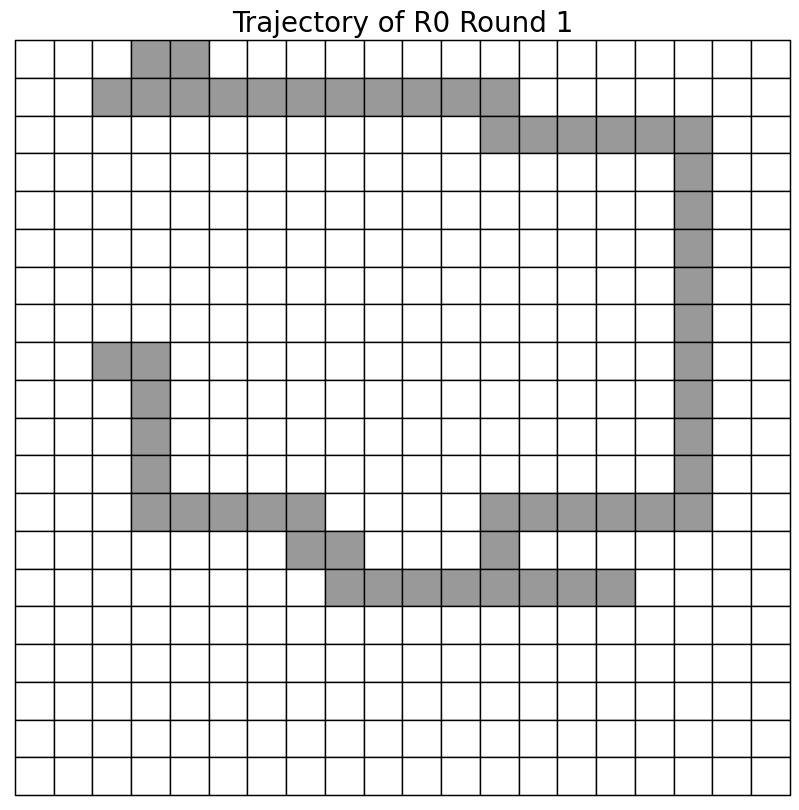

<Figure size 432x288 with 0 Axes>

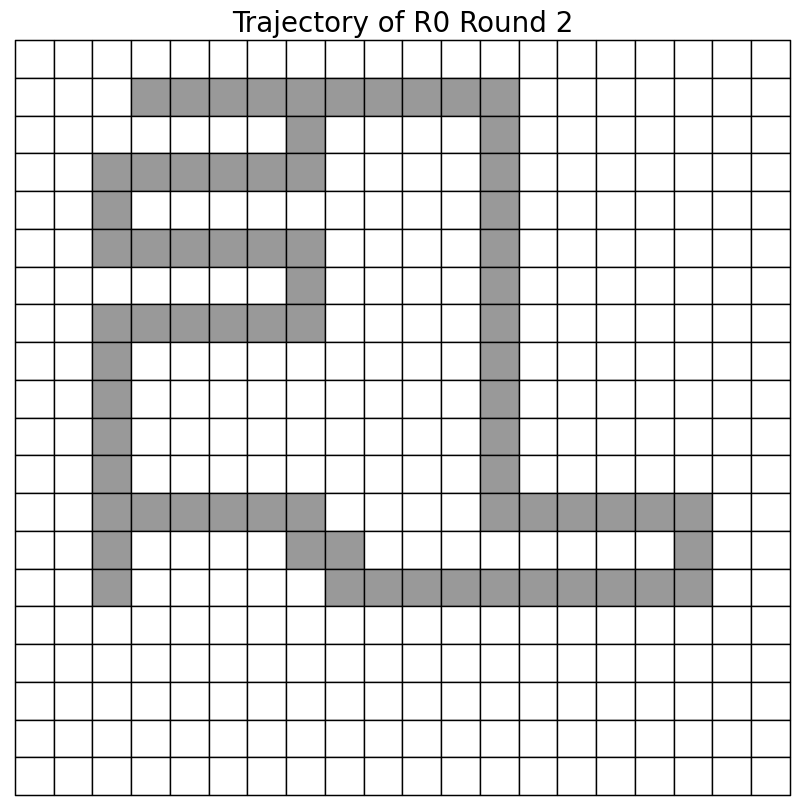

<Figure size 432x288 with 0 Axes>

In [29]:
"""
Path of agile light-duty robot
"""
path_detect_round[1] = path_detect_round[1][len(path_detect_round[0]): len(path_detect_round[1])]
for n in range(len(path_detect_round)):
    mm = copy.deepcopy(map_original)
    draw_path(mm, path_detect_round[n], fig_folder, "Trajectory of R0 Round " + str(n + 1))


The current step is  22
The current positions are [array([1, 0]), array([ 0, 10]), array([18, 13]), array([16,  4])]
Step  22 Robot 0 Task left:  ['w25', 'w35']
Step  22 Robot 1 Task left:  ['w8', 'w167']
Step  22 Robot 2 Task left:  ['w43', 'w75', 'w55']
Step  22 Robot 3 Task left:  ['w163', 'w178', 'w15']
Step  22 Robot 0 Task left:  ['w25', 'w35']
Step  22 Robot 1 Task left:  ['w8', 'w167']
Step  22 Robot 2 Task left:  ['w43', 'w75', 'w55']
Step  22 Robot 3 Task left:  ['w163', 'w178', 'w15']
Step  22 Robot 0 Task left:  ['w25', 'w35']
Step  22 Robot 1 Task left:  ['w8', 'w167']
Step  22 Robot 2 Task left:  ['w43', 'w75', 'w55']
Step  22 Robot 3 Task left:  ['w163', 'w178', 'w15']
Step  23 Robot 0 Task left:  ['w25', 'w35']
Step  23 Robot 1 Task left:  ['w8', 'w167']
Step  23 Robot 2 Task left:  ['w43', 'w75', 'w55']
Step  23 Robot 3 Task left:  ['w163', 'w178', 'w15']
Step  23 Robot 0 Task left:  ['w25', 'w35']
Step  23 Robot 1 Task left:  ['w8', 'w167']
Step  23 Robot 2 Task left:

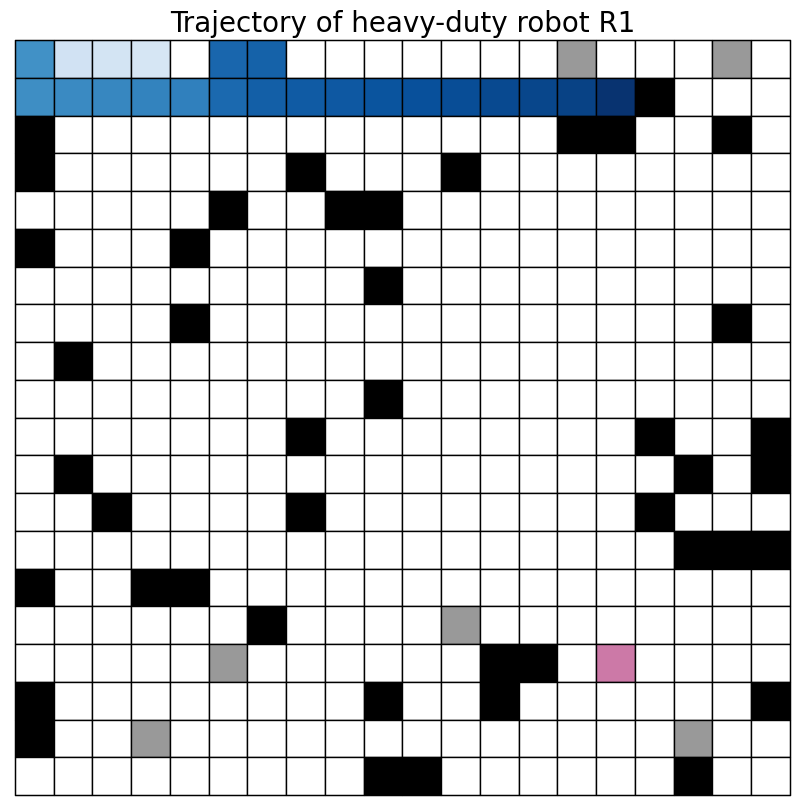

<Figure size 432x288 with 0 Axes>

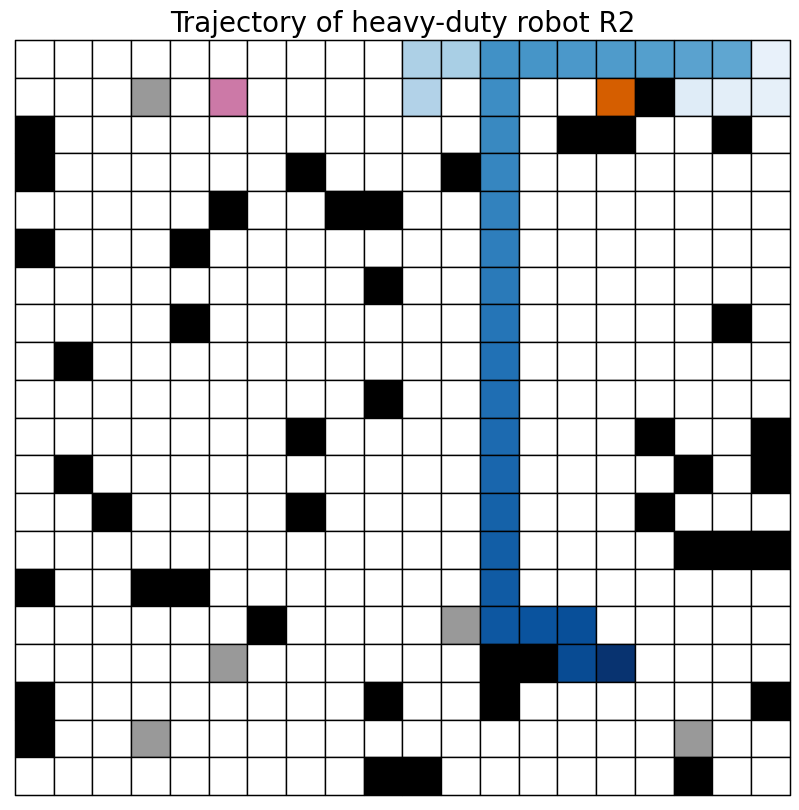

<Figure size 432x288 with 0 Axes>

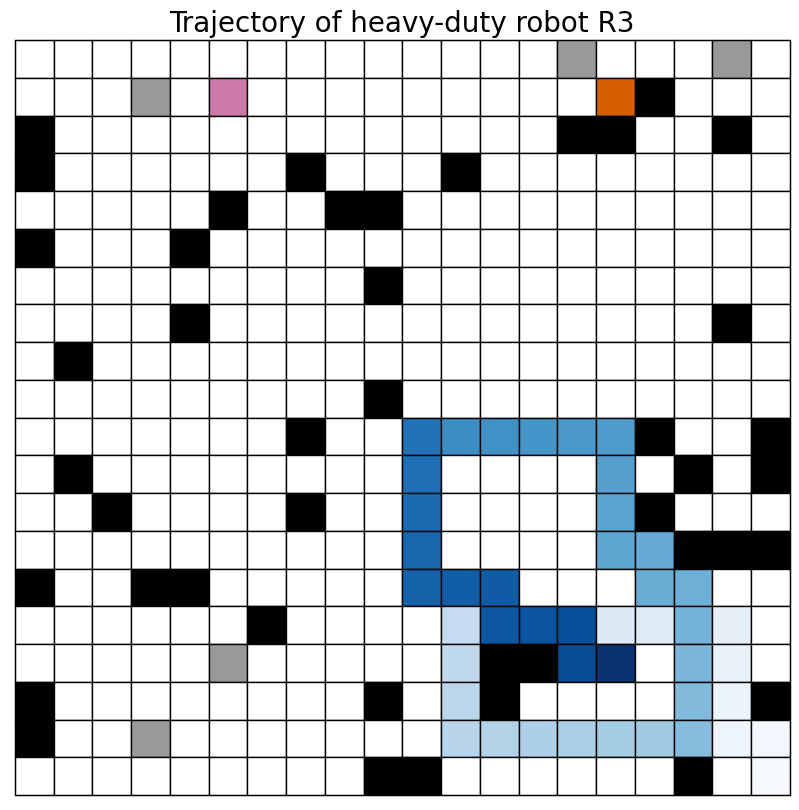

<Figure size 432x288 with 0 Axes>

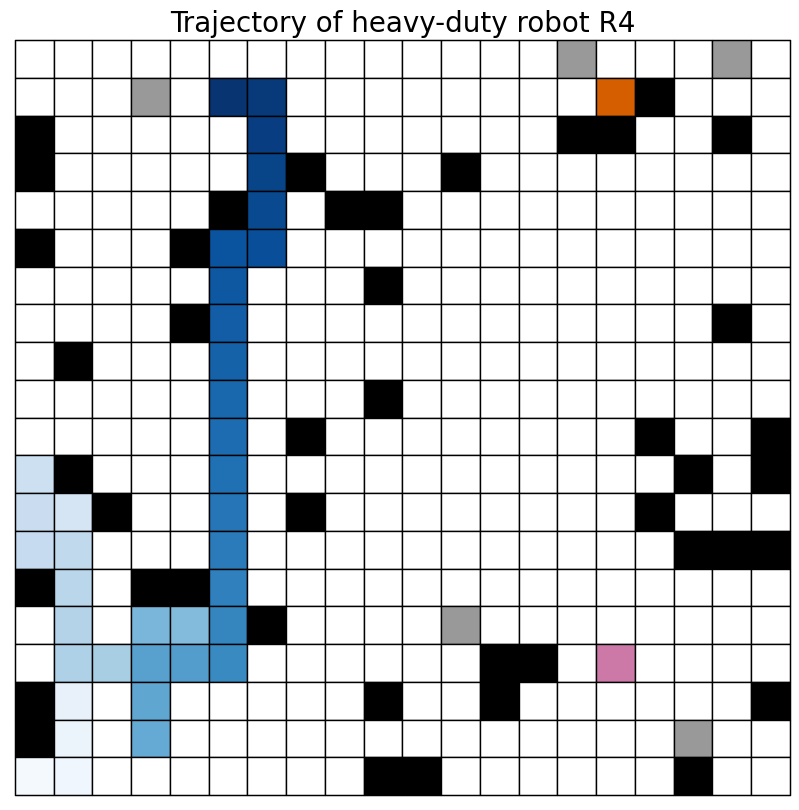

<Figure size 432x288 with 0 Axes>

In [30]:
"""
Get the data ready for plot and video
"""

independent_path_2d, record_working_region, record_task_left = \
    complete_path(world, v_light, independent_path_2d, states_work_region, record_working_region, record_task_left)

record_path_all = world.agents_light.path
for i in range(num_agent_heavy):
    record_path_all = np.concatenate((record_path_all, world.agents_heavy[i].path), axis=1)
    draw_path(map_obs_work, independent_path_2d[i], fig_folder, "Trajectory of heavy-duty robot R" + str(i + 1))

st = len(record_working_region[0])
for i in range(st, len(record_path_all)):
    for j in range(num_agent_heavy):
        record_working_region[j].append(record_working_region[j][-1])
        record_task_left[j].append(record_task_left[j][-1])

# animate_solution(map_obs_work, record_path_all, record_working_region, record_task_left, r_0, r_i, v_light,
#                  fig_folder, video=True)
